<div style = 'text-align: center;'>
    <img src = '../images/ga_logo_large.png'>
</div>

---
## **Capstone Project: Ride BigApple** 🚖🍎

------
#### **Problem Statement**
Can yellow cab fares be predicted within New York City's five boroughs based on time of the day, time of the year and certain high passenger areas?<br>
The aim here is to use existing historical data of NYC cab rides spanning several years and building a model that can be integrated into a simple app to request a taxi ride and predict the expected fare and distance for the passenger.

----
#### **Data**
The original <a href = 'https://www.kaggle.com/c/new-york-city-taxi-fare-prediction'>dataset</a> contains 55.4 million rows and eight columns. Given the vast size of this dataset, only 60 thousand rows were randomly sampled.  This subset is labeled `nyc_taxidata_60k.csv`.  The original eight columns, in order, are: `key`, `fare_amount`, `pickup_datetime`, `pickup_longitude`, `pickup_latitude`, `dropoff_longitude`, `dropoff_latitude` and `passenger_count`.<br>
Columns `key` and `pickup_datetime` contained the same information.  As part of the cleaning process, `pickup_datetime` was dropped and new columns were created from the `key` column.  Those are `year`, `month`, `day_of_week`, `hour`, and `minute`.  An additonal column, `geodesic_distance`, was created by calculating said distance between the pickup and dropoff coordinates for each record.<br>
After the data cleaning process was completed, the following datasets were generated and saved:<br>
**Cleaned up datasets**<br>
* `taxi_clean_set_v1.csv`: This file has 53,353 rows and 13 columns.
* `taxi_clean_set_v2.csv`: This file has 53,351 rows and 13 columns.
* `taxi_clean_set_v3.csv`: This file has 53,351 rows and 36 columns, the additional 23 columns are mostly engineered features and auxiliary columns used to help create plots, as well as other features.

----
#### **Consulted Sources**
Some parts of this analysis rely on the outside sources listed below.  These were consulted to gain a better understanding into the factors that make up a metered yellow cab fare in NYC, as well as to learn more about information and stats published by local SMEs, including the the New York City Taxi and Limousine Commission (TLC).<br>
* <a href = 'https://www.dylanhoffman.com/blog/2022/11/17/nyc-taxi-fares-to-increase-by-23-for-2023'>New York City Fares to Increase by 23% For 2023</a>
* <a href = 'https://www.nbcnewyork.com/news/local/taxi-fare-hike-september-4-drivers-scheduled-inspections-mixed-fares/1956850/'>NYC Cab Fare Hike Takes Effect Tuesday</a>
* <a href = 'https://web.archive.org/web/20181024231444/http://www.nyc.gov/html/tlc/downloads/pdf/2014_taxicab_fact_book.pdf'>2014 Taxicab Fact Book</a>

------
#### **Data Import and Cleaning**

In [57]:
# import personal library
import importlib.util
import sys

path_to_library = '../scripts/personal_library.py'

# load module
spec = importlib.util.spec_from_file_location('personal_library', path_to_library)
lu = importlib.util.module_from_spec(spec)
sys.modules['personal_library'] = lu
spec.loader.exec_module(lu)

In [59]:
# modules needed for this notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [61]:
# read in file
file_path = '../data/nyc_taxidata_60k.csv'

taxi = pd.read_csv(file_path)
taxi.shape

(60000, 8)

In [7]:
taxi.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-10-31 03:32:00.000000130,3.7,2010-10-31 03:32:00 UTC,-73.982163,40.762762,-73.987518,40.760543,1
1,2014-11-20 22:50:22.0000002,14.5,2014-11-20 22:50:22 UTC,-73.995560,40.759405,-73.968201,40.804051,1
2,2010-01-26 19:27:55.0000002,11.7,2010-01-26 19:27:55 UTC,-74.001313,40.736943,-73.994137,40.699002,1
3,2010-03-22 19:00:00.000000191,4.5,2010-03-22 19:00:00 UTC,-74.005897,40.770640,-74.008753,40.769735,1
4,2011-02-26 08:57:11.0000002,4.9,2011-02-26 08:57:11 UTC,-73.984917,40.749153,-74.000801,40.757591,1


The `key` column may later be used as a time index. The first few rows match the information listed in the `pickup_datetime` column. It makes sense to sort by the column and check again at the start and tail end of the dataset to confirm.

In [9]:
# earliest rides
taxi.sort_values(by = 'key').head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
37279,2009-01-01 00:48:11.0000002,11.0,2009-01-01 00:48:11 UTC,-73.993578,40.721298,-73.967109,40.756657,4
24037,2009-01-01 00:54:13.0000001,12.2,2009-01-01 00:54:13 UTC,-73.985358,40.744602,-73.956073,40.778083,2
46429,2009-01-01 01:07:13.0000001,5.4,2009-01-01 01:07:13 UTC,-73.978859,40.750516,-73.968175,40.758468,1
30480,2009-01-01 01:12:02.0000001,11.0,2009-01-01 01:12:02 UTC,-73.987317,40.768627,-74.007565,40.740797,1
45530,2009-01-01 04:34:56.0000001,8.2,2009-01-01 04:34:56 UTC,-73.988965,40.736905,-74.001923,40.747579,1


In [10]:
# most recent rides
taxi.sort_values(by = 'key').tail()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
25935,2015-06-30 14:42:23.0000004,4.0,2015-06-30 14:42:23 UTC,-73.952606,40.778427,-73.949661,40.772446,4
25402,2015-06-30 15:32:34.0000004,5.0,2015-06-30 15:32:34 UTC,-73.954971,40.788841,-73.954407,40.778969,1
43154,2015-06-30 18:46:26.0000001,11.5,2015-06-30 18:46:26 UTC,-73.975121,40.755234,-73.978989,40.763821,1
55460,2015-06-30 18:58:55.0000009,14.5,2015-06-30 18:58:55 UTC,-73.955399,40.768505,-73.984917,40.726761,1
31487,2015-06-30 19:43:39.0000008,10.0,2015-06-30 19:43:39 UTC,-73.991318,40.742397,-73.992409,40.767353,1


Indeed, the `key` and `pickup_datetime` columns contain the same information, for the sake of simplicity, drop the latter.

In [63]:
taxi.drop(columns = 'pickup_datetime', inplace = True)
taxi.head(1)

,key,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-10-31 03:32:00.000000130,3.7,-73.982163,40.762762,-73.987518,40.760543,1


**Data Types**

In [16]:
taxi.dtypes

key                   object
fare_amount          float64
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

All data types look consistent with the columns except the `key` column.  Convert that column to a `datetime` object.

In [65]:
taxi['key'] = pd.to_datetime(taxi['key'])
# confirm
taxi.dtypes

key                  datetime64[ns]
fare_amount                 float64
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count               int64
dtype: object

Now that `key` is a `datetime` object, new columns can be created for specific date/time elements of interest.  Before doing that, though, more cleaning is needed.

**Null Values**

In [67]:
taxi.isnull().sum()

key                  0
fare_amount          0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    2
dropoff_latitude     2
passenger_count      0
dtype: int64

There are just two missing values in this sample. They can be dropped.

In [69]:
print(f'Before: {taxi.shape}')
taxi.dropna(inplace = True)
print(f'After: {taxi.shape}')

Before: (60000, 7)
After: (59998, 7)


---
#### **Columns**

---
**Column**: `fare_amount`

In [71]:
# fare amout stats
taxi['fare_amount'].describe()

count    59998.000000
mean        11.324794
std          9.858193
min         -7.800000
25%          6.000000
50%          8.500000
75%         12.500000
max        377.750000
Name: fare_amount, dtype: float64

Having negative fares does not make sense. In fact, per consulted sources, the base <a href = 'https://www.nbcnewyork.com/news/local/taxi-fare-hike-september-4-drivers-scheduled-inspections-mixed-fares/1956850/'>fare</a> for NYC taxis is 2.50 dollars. This was as of Sept. 04, 2012 (rides in dataset span from 2009 thru 2015). For the sake of simplicity, stick to this value.<br>
Check the number of records with fares below that threshold and drop.

In [73]:
print(f"Rows with fares under $2.50: {taxi[taxi['fare_amount'] < 2.50].shape[0]}")

Rows with fares under $2.50: 4


Just four records, drop them from the dataset.

In [75]:
print(f'Before: {taxi.shape}')
taxi.drop(index = taxi[taxi['fare_amount'] < 2.50].index, inplace = True)
taxi.reset_index(drop = True, inplace = True)
print(f'After: {taxi.shape}')

Before: (59998, 7)
After: (59994, 7)


In [77]:
# check fare stats again
taxi['fare_amount'].describe()

count    59994.000000
mean        11.325900
std          9.857571
min          2.500000
25%          6.000000
50%          8.500000
75%         12.500000
max        377.750000
Name: fare_amount, dtype: float64

The figures make sense up to the 3rd quartile.  The max, though is 377.75 dollars.  Check the stats for records above 12.50.

In [79]:
taxi[taxi['fare_amount'] > 12.50]['fare_amount'].describe()

count    14711.000000
mean        23.437054
std         13.556688
min         12.600000
25%         14.900000
50%         18.100000
75%         27.300000
max        377.750000
Name: fare_amount, dtype: float64

Visualize this subset's distribution to get a better understanding on the outliers.

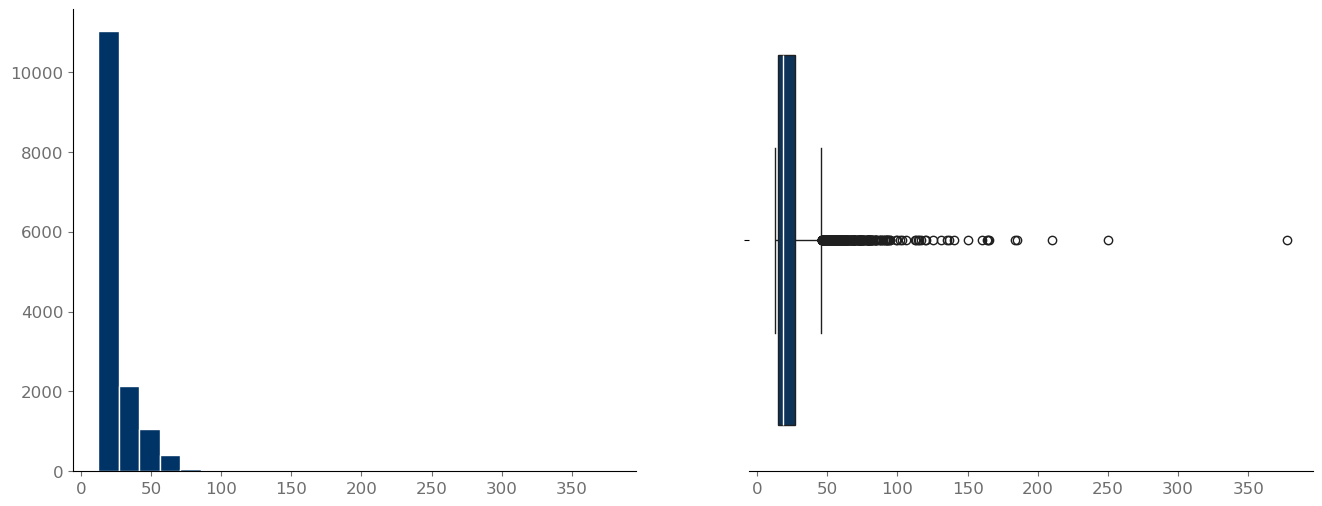

In [81]:
lu.plot_hist_box(taxi[taxi['fare_amount'] > 12.50], col_name = 'fare_amount')
plt.savefig('../images/hist_boxplot_fares_over_12_50.png')

All the outliers are above 50 dollars.  For NYC, based on consulted sources and experience, a cab drive can exceed 50 dollars (flat rate between Manhattan and JFK as of time of dataset was 52 dollars), or if it's unusually long (i.e. from Lower Manhattan to the farthest corners of the outer boroughs).  However, given the size of this dataset (59,994 rows at this juncture of the cleanup process) having just a few outliers above 150 dollars warrants a quick look to see if those fares are realistic or not.

In [84]:
taxi[taxi['fare_amount'] > 150]

,key,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
921,2014-04-24 12:19:35.000000300,160.00,-74.185481,40.698439,-74.187104,40.693440,2
1129,2014-10-27 11:16:00.000000105,184.00,-73.541077,41.113127,0.000000,0.000000,1
4219,2011-08-08 12:42:00.000000440,250.00,-74.184712,40.564758,-74.184712,40.564758,1
9260,2014-06-05 23:30:09.000000200,185.00,-74.375056,40.737231,-74.375023,40.737228,1
37962,2014-12-11 22:12:00.000000204,164.50,-73.992857,40.758077,-74.191497,40.813237,1
38634,2013-05-09 11:24:45.000000100,163.91,-73.784198,40.648629,-74.247136,40.621692,1
46448,2015-04-26 21:50:05.000000200,377.75,-73.862778,40.768799,-73.119949,41.276634,1
51687,2012-06-27 01:30:46.000000100,210.00,-74.012195,40.715851,-74.012175,40.715841,1
58848,2015-06-25 23:26:17.000000300,165.00,-73.421967,40.783943,-73.422234,40.783886,1


It is just nine records, and one of them has bad dropoff coordinates, all zeros, so that one row needs to be discarded. Given this finding, check first how many more records have longitude or latitude values of zero for either the pickup or the dropoff location.  Distances cannot be determined without that information.

In [86]:
# create boolean mask for all coordinates
zero_coordinates = (taxi[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']] == 0).any(axis=1)
zero_coordinates.value_counts()

False    58834
True      1160
Name: count, dtype: int64

About 2% of the records will need to be discarded.  Before doing so, take a quick look to confirm.

In [88]:
taxi[zero_coordinates]

,key,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
8,2012-02-20 17:00:59.000000400,6.9,0.000000,0.000000,0.0,0.000000,2
44,2012-03-29 22:10:00.000000112,19.3,0.000000,0.000000,0.0,0.000000,1
83,2012-03-22 08:31:00.000000320,5.7,0.000000,0.000000,0.0,0.000000,1
240,2014-09-16 08:38:00.000000109,2.5,0.000000,0.000000,0.0,0.000000,1
308,2009-11-25 07:52:35.000000100,18.1,0.000000,0.000000,0.0,0.000000,1
...,...,...,...,...,...,...,...
59739,2012-08-09 15:56:00.000000158,10.1,-74.003960,40.742862,0.0,40.721647,1
59788,2014-07-22 07:08:00.000000160,6.0,0.000000,0.000000,0.0,0.000000,1
59792,2009-01-31 12:09:45.000000100,10.9,0.000000,0.000000,0.0,0.000000,1
59871,2010-09-21 18:07:00.000000159,32.1,0.000000,0.000000,0.0,0.000000,1


Indeed, these are all bad records.  Drop them from the dataset.

In [90]:
print(f'Before: {taxi.shape}')
taxi.drop(index = taxi[zero_coordinates].index, inplace = True)
taxi.reset_index(drop = True, inplace = True)
print(f'After: {taxi.shape}')

Before: (59994, 7)
After: (58834, 7)


Now that these bad records have been dropped, let's go back to the `fare_amount` outliers.

In [92]:
taxi[taxi['fare_amount'] > 150]

,key,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
904,2014-04-24 12:19:35.000000300,160.00,-74.185481,40.698439,-74.187104,40.693440,2
4144,2011-08-08 12:42:00.000000440,250.00,-74.184712,40.564758,-74.184712,40.564758,1
9087,2014-06-05 23:30:09.000000200,185.00,-74.375056,40.737231,-74.375023,40.737228,1
37213,2014-12-11 22:12:00.000000204,164.50,-73.992857,40.758077,-74.191497,40.813237,1
37871,2013-05-09 11:24:45.000000100,163.91,-73.784198,40.648629,-74.247136,40.621692,1
45523,2015-04-26 21:50:05.000000200,377.75,-73.862778,40.768799,-73.119949,41.276634,1
50675,2012-06-27 01:30:46.000000100,210.00,-74.012195,40.715851,-74.012175,40.715841,1
57713,2015-06-25 23:26:17.000000300,165.00,-73.421967,40.783943,-73.422234,40.783886,1


As expected, only eight records are left. Without having calculated the distances yet, a decision on whether to drop them or not cannot be made yet.  Keep these records for now as they only account for about one hundreth of the data, which is negligible.<br>
Let's take a look at the entire distribution from 2.50 USD all the way to 377.75 USD.

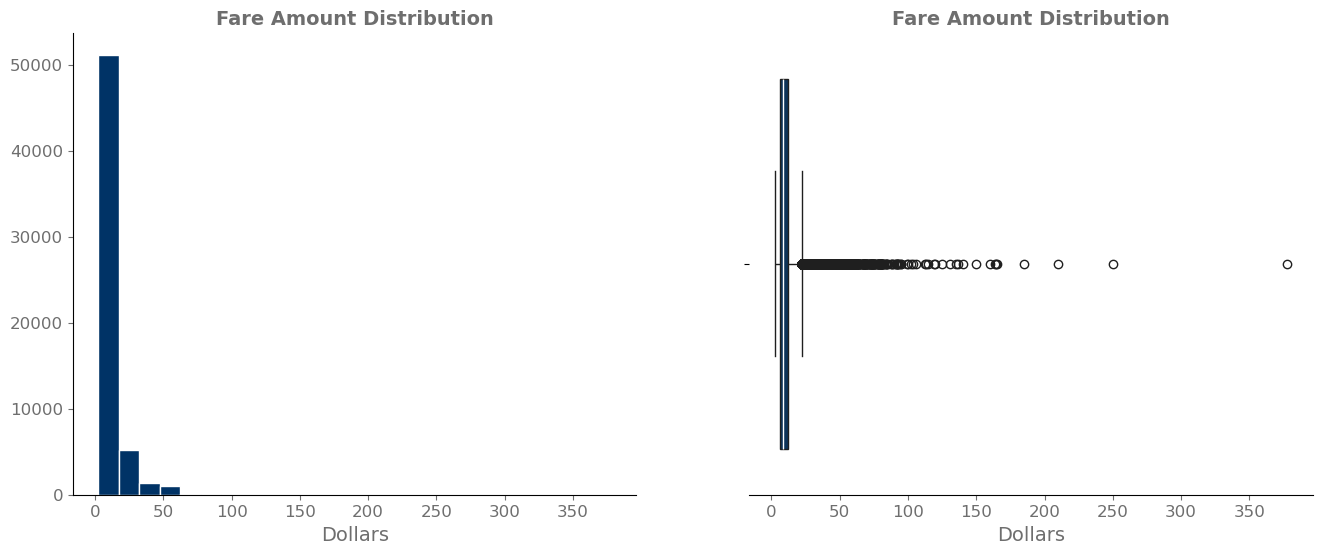

In [94]:
lu.plot_hist_box(taxi, col_name = 'fare_amount', title = 'Fare Amount Distribution', xlabel = 'Dollars')
plt.savefig('../images/hist_boxplot_fare_amount.png')

In [46]:
# check stats again
taxi['fare_amount'].describe()

count    58834.000000
mean        11.317511
std          9.802747
min          2.500000
25%          6.000000
50%          8.500000
75%         12.500000
max        377.750000
Name: fare_amount, dtype: float64

The entire range of values for `fare_amount` looks reasonable. The mean of 11.32 is consistent with the average fare listed in the consulted <a href = 'https://web.archive.org/web/20181024231444/http://www.nyc.gov/html/tlc/downloads/pdf/2014_taxicab_fact_book.pdf'>sources</a>.  Even the outliers, without taking distance into account, look consistent because they're a few.  That being said, once distances between pickup and dropoff locations are calculated, the `fare_amount` column must be revisited again.

---
**Columns**: `pickup_longitude`, `pickup_latitude`, `dropoff_longitude` and `dropoff_latitude`.

Ensure all pickup and dropoff locations are actually within NYC.  Research indicated the following parameters:<br>
*  Northernmost point: 40.915 degrees N latitude
*  Southernmost point: 40.496 degrees N latitude
*  Westernmost point: -74.256 degrees W longitude
*  Easternmost point: -73.702 degrees W longitude

<br>These four points only create a box that encompass the entire city of New York. Since the city borders don't actually follow a box outline, some pickup/dropoff points within this box may lie outside city limits.  However, this first step helps discard any coordinates that may be geographically wrong (in another part of the country/world) and any coordinates immediately outside the box, which are obviously not within NYC. Once addresses are determine, that will help discard the remaining points.

In [50]:
# drop rides north of 40.915 degrees
coordinates = (taxi[['pickup_latitude', 'dropoff_latitude']] > 40.915).any(axis=1)

print(f'Before: {taxi.shape}')
taxi.drop(index = taxi[coordinates].index, inplace = True)
taxi.reset_index(drop = True, inplace = True)
print(f'After: {taxi.shape}')

Before: (58834, 7)
After: (58790, 7)


In [52]:
# drop rides south of 40.496 degrees
coordinates = (taxi[['pickup_latitude', 'dropoff_latitude']] < 40.496).any(axis=1)

print(f'Before: {taxi.shape}')
taxi.drop(index = taxi[coordinates].index, inplace = True)
taxi.reset_index(drop = True, inplace = True)
print(f'After: {taxi.shape}')

Before: (58790, 7)
After: (58741, 7)


In [54]:
# drop rides west of -74.256 degrees
coordinates = (taxi[['pickup_longitude', 'dropoff_longitude']] < -74.256).any(axis=1)

print(f'Before: {taxi.shape}')
taxi.drop(index = taxi[coordinates].index, inplace = True)
taxi.reset_index(drop = True, inplace = True)
print(f'After: {taxi.shape}')

Before: (58741, 7)
After: (58734, 7)


In [56]:
# drop rides east of -73.702 degrees
coordinates = (taxi[['pickup_longitude', 'dropoff_longitude']] > -73.702).any(axis=1)

print(f'Before: {taxi.shape}')
taxi.drop(index = taxi[coordinates].index, inplace = True)
taxi.reset_index(drop = True, inplace = True)
print(f'After: {taxi.shape}')

Before: (58734, 7)
After: (58707, 7)


Total rows dropped were 127, that accounts for less than 1% of the data.<br>
Now check the stats for each of the coordinate columns to make sure the data is within the imaginary geographical box that's been set for this exercise.

In [59]:
taxi[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']].describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
count,58707.000000,58707.000000,58707.000000,58707.000000
mean,-73.975603,40.750845,-73.974666,40.751300
std,0.034265,0.026932,0.033789,0.030709
min,-74.208238,40.528705,-74.247136,40.517088
25%,-73.992170,40.736654,-73.991512,40.735780
50%,-73.982120,40.753363,-73.980544,40.753966
75%,-73.968456,40.767472,-73.965528,40.768360
max,-73.718987,40.906545,-73.708780,40.912382


All coordinates are correct and within the box.

----
**Column**: `passenger_count`

In [61]:
# check stats
taxi['passenger_count'].value_counts().sort_index()

passenger_count
0      208
1    40493
2     8698
3     2656
4     1313
5     4113
6     1226
Name: count, dtype: int64

Passenger count cannot be zero.  However, the aim of this exercise is to predict the fare amount when a passenger requests a ride, and in NYC fares are NOT determined by the number of passengers, but rather by the initial base fare, plus distance traveled, time spent in slow traffic and tolls.  Therefore, this column can be ignored.  For the sake of data consistency, though, all rows where passenger count is zero will be filled with number 1.

In [63]:
# fill in with ones
taxi.loc[taxi['passenger_count'] == 0, 'passenger_count'] = 1

# confirm
taxi['passenger_count'].value_counts().sort_index()

passenger_count
1    40701
2     8698
3     2656
4     1313
5     4113
6     1226
Name: count, dtype: int64

----
**New Columns**: `year`, `month`, `day_of_week`, `hour` and `minute`

Parse the `key` column, which is a `datetime` object, to extract different time elements and create new columns with them.

In [65]:
# create new columns from key
print(f'Before: {taxi.shape}')

taxi['year'] = taxi['key'].dt.year
taxi['month'] = taxi['key'].dt.month_name()
taxi['day_of_week'] = taxi['key'].dt.day_name()
taxi['hour'] = taxi['key'].dt.hour
taxi['minute'] = taxi['key'].dt.minute

print(f'After: {taxi.shape}')

# see first row
taxi.head(1)

Before: (58707, 7)
After: (58707, 12)


,key,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day_of_week,hour,minute
0,2010-10-31 03:32:00.000000130,3.7,-73.982163,40.762762,-73.987518,40.760543,1,2010,October,Sunday,3,32


All new columns successfully created. Confirm now that the data types are correct.

In [67]:
taxi.dtypes

key                  datetime64[ns]
fare_amount                 float64
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count               int64
year                          int32
month                        object
day_of_week                  object
hour                          int32
minute                        int32
dtype: object

---
**Column:** `year`

In [69]:
# year counts
taxi['year'].value_counts().sort_index()

year
2009    9241
2010    8812
2011    9252
2012    9477
2013    9027
2014    8812
2015    4086
Name: count, dtype: int64

Investigate why 2015 has a significantly lower count.

In [71]:
taxi[taxi['year'] == 2015]['month'].value_counts().sort_index()

month
April       700
February    631
January     699
June        659
March       700
May         697
Name: count, dtype: int64

Only the first six months of 2015 are available. This may bias the data by just having half of one year.  Although these many rows account for 6.9% of the dataset, it's better to drop them to keep all the years consistent.

In [73]:
print(f'Before: {taxi.shape}')
taxi.drop(index = taxi[taxi['year'] == 2015].index, inplace = True)
taxi.reset_index(drop = True, inplace = True)
print(f'After: {taxi.shape}')

Before: (58707, 12)
After: (54621, 12)


In [75]:
# check year counts again
taxi['year'].value_counts(normalize = True).sort_index()

year
2009    0.169184
2010    0.161330
2011    0.169385
2012    0.173505
2013    0.165266
2014    0.161330
Name: proportion, dtype: float64

The full year counts are well balanced.

-----
**Column**: `month`

In [77]:
taxi['month'].value_counts(normalize = True)

month
March        0.090368
May          0.087604
April        0.086139
June         0.085279
October      0.085169
July         0.083045
November     0.082313
January      0.081910
December     0.081324
September    0.080738
August       0.078230
February     0.077882
Name: proportion, dtype: float64

The counts for `month` are well balanced.

-------
**Column**: `day_of_week`

In [79]:
taxi['day_of_week'].value_counts(normalize = True)

day_of_week
Friday       0.155343
Saturday     0.151535
Thursday     0.149118
Wednesday    0.144120
Tuesday      0.141374
Sunday       0.130554
Monday       0.127954
Name: proportion, dtype: float64

The counts for all days of the week are well balanced.

----
**Column**: `hour`

Verify that the hours are from 0 to 23.

In [81]:
taxi['hour'].describe()[['min', 'max']]

min     0.0
max    23.0
Name: hour, dtype: float64

Values are within expected parameters.

----
**Column**: `minute`

Verify that the minutes are bound between 0 and 59.

In [86]:
taxi['minute'].describe()[['min', 'max']]

min     0.0
max    59.0
Name: minute, dtype: float64

Values are within expected parameters.

---
**Columns Cleanup Summary**

Check all columns and data types again.

In [88]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54621 entries, 0 to 54620
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   key                54621 non-null  datetime64[ns]
 1   fare_amount        54621 non-null  float64       
 2   pickup_longitude   54621 non-null  float64       
 3   pickup_latitude    54621 non-null  float64       
 4   dropoff_longitude  54621 non-null  float64       
 5   dropoff_latitude   54621 non-null  float64       
 6   passenger_count    54621 non-null  int64         
 7   year               54621 non-null  int32         
 8   month              54621 non-null  object        
 9   day_of_week        54621 non-null  object        
 10  hour               54621 non-null  int32         
 11  minute             54621 non-null  int32         
dtypes: datetime64[ns](1), float64(5), int32(3), int64(1), object(2)
memory usage: 4.4+ MB


All columns look correct.  The data types for each one correspond to the values assigned to each column and there are no missing values.  At this juncture in the cleanup process, the dataset retains 91.04% of the original rows with new, informative columns extracted from the `key` column. <br>

----
**Pickup and Dropoff Locations**

Let's take a quick look at the geographical distribution of both pickup and dropoff locations within the spatial parameters that were set earlier.

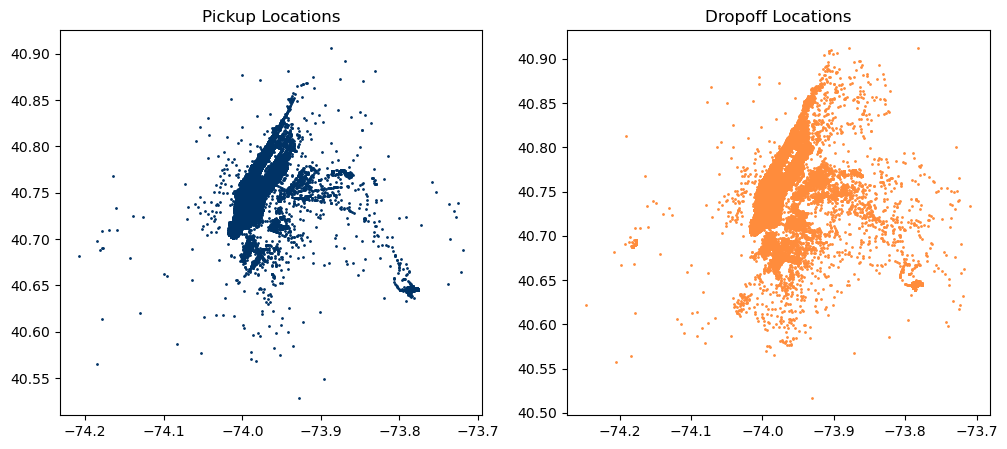

In [156]:
# scatter plots of pickups and dropoffs

# container
plt.figure(figsize = (12, 5))

# subplots
plot1 = plt.subplot(1, 2, 1)
plot2 = plt.subplot(1, 2, 2)

plot1.scatter(taxi['pickup_longitude'], taxi['pickup_latitude'], s = 1, color = '#003366')
plot1.set_title('Pickup Locations')

plot2.scatter(taxi['dropoff_longitude'], taxi['dropoff_latitude'], s = 1, color = '#ff8c3c')
plot2.set_title('Dropoff Locations');

plt.savefig('../images/scatterplots_all_pickups_and_dropoffs.png');

The countours of the city of New York are quite visible in these two charts.  One can infer that the vast majority of the pickups and dropoffs in this dataset took place within city boundaries.<br><br>
Based on research, NYC taxis that are licensed by the Taxi and Limousine Comission (TLC), cannot, by law, pickup rides outside the city boundaries.  The chart on the left, however, indicates otherwise.  Although not a lot in relative to the size of the dataset, many pickups occurred in New Jersey, and several others in Westchester County (north of The Bronx) as well as Nassau County (east of Queens).<br><br>
If the dataset contained the actual pickup and dropoff addresses, then it would be very easy to get rid of those specific rows, but that's not the case.  There is, however, one way to get those addresses from the recorded longitude and latitude coordinates, by using the `googlemaps` API, but that would entail racking up some charges. So, it's best to hold on that, for now.<br><br>
Based on consulted sources, about 90% of taxi pickup activity actually takes place within Manhattan, specially within its core, which is south of 96th Street.  The high concentration of pickups below that thorouhfare is clearly visible in the chart.  This is important to know because it indicates that the very few pickup points outside city boundaries should not weigh heavily on the data. So, with that in mind, and for the sake of this exercise, we'll consider the entire spatial longitude/latitude boundary as NYC as a whole.<br><br>
As far as dropoff locations, once a passenger hails a cab, if the driver agrees, the passenger can be dropped off anywhere outside the city, even in another state.  The chart on the right basically illustrates that. There are a lot more dropoff points north of Manhattan's 96th Street, as well as outside Manhattan, especially Queens and Brooklyn.  Anyone familiar with the geography of the region will also notice a little cluster of dropoffs at Newark's international airport in New Jersey.

-----
**New Column** `geodesic_distance`

Without pickup and dropoff addresses, one cannot determine actual street distance. Although the `googlemaps` API can determine that from the available longitude/latitude data (at a cost), there is another type of distance that can be calculated (at no cost) from this data: geodesic distance.<br>
>**Definition**: _Geodesic distance is the shortest distance between two points on a curved surface, such as the Earth, measured along the surface itself rather than through it._

We may be able to use this geodesic distance to help our model estimate a taxi fare. In order to calculate this distance, and build a column out of this data, we'll use one of python's libraries: `geopy`.

In [90]:
# import geodesic module
from geopy.distance import geodesic
# source: https://geopy.readthedocs.io/en/stable/

Now extract geodesic distance (in kilometers) from availabe coordinates and create a new column with this information for each row in the dataset.

In [93]:
# apply get_geo_distance() from personal_library
taxi['geodesic_distance'] = taxi.apply(lambda row: lu.get_geo_distance(
                                                            row['pickup_longitude'], row['pickup_latitude'], 
                                                            row['dropoff_longitude'], row['dropoff_latitude']),
                                                            axis=1)

In [94]:
# confirm
taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54621 entries, 0 to 54620
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   key                54621 non-null  datetime64[ns]
 1   fare_amount        54621 non-null  float64       
 2   pickup_longitude   54621 non-null  float64       
 3   pickup_latitude    54621 non-null  float64       
 4   dropoff_longitude  54621 non-null  float64       
 5   dropoff_latitude   54621 non-null  float64       
 6   passenger_count    54621 non-null  int64         
 7   year               54621 non-null  int32         
 8   month              54621 non-null  object        
 9   day_of_week        54621 non-null  object        
 10  hour               54621 non-null  int32         
 11  minute             54621 non-null  int32         
 12  geodesic_distance  54621 non-null  float64       
dtypes: datetime64[ns](1), float64(6), int32(3), int64(1), object(

The `geodesic_distance` column was successfully added and with the correct data type. Let's now check its contents and do some cleanup, if needed.

In [97]:
# stats
taxi['geodesic_distance'].describe()

count    54621.000000
mean         3.290616
std          3.545223
min          0.000000
25%          1.255383
50%          2.138931
75%          3.872992
max         39.277375
Name: geodesic_distance, dtype: float64

The average distance of 3.3km (2.1 miles) is realistic.  Per consulted sources, the actual average distance traveled by taxi in NYC is 2.6 miles.  Since we're using geodesic distances, rather than actual distances, the fact that the average for this dataset is lower is a good indicator.  Actual distances are always greater than geodesic distances because of street layouts, natural barriers like rivers, and local topography. Thanks to Manhattan's grid, the average difference between actual street distance and geodesic distance is about 15%, and for the outer boroughs it ranges from 20% to 25%. This is important to later estimate actual street distances. Therefore, the average geodesic distance of 2.1 miles would approximately be between 2.42 and 2.63 actual miles.  Once again, this is in alignment with the actual average.<br><br>
The maximum recorded distance is also realistic at 34.5km (21.6 miles).  However it would make sense to make sure the `fare_amount` is in alignment with such distance.<br><br>
Lastly, some distances are recorded as zero, which is inaccurate.  Take a look at these rows, quantify and if needed, impute the values or delete the records.

In [99]:
# check zero distances
print(f"Count: {taxi[taxi['geodesic_distance'] == 0].shape[0]}")

Count: 634


In [101]:
# fare stats for these rows
taxi[taxi['geodesic_distance'] == 0]['fare_amount'].describe()

count    634.000000
mean      11.756751
std       16.833937
min        2.500000
25%        4.500000
50%        6.750000
75%       10.100000
max      250.000000
Name: fare_amount, dtype: float64

In [103]:
# check coordinates
taxi[taxi['geodesic_distance'] == 0][['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']]

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
15,-73.983737,40.767842,-73.983737,40.767842
38,-73.959046,40.819685,-73.959046,40.819685
154,-74.011069,40.786596,-74.011069,40.786596
206,-73.942443,40.751632,-73.942443,40.751632
307,-73.918663,40.771946,-73.918663,40.771946
...,...,...,...,...
54287,-74.002977,40.739162,-74.002977,40.739162
54385,-73.969007,40.762015,-73.969007,40.762015
54431,-73.863300,40.769417,-73.863300,40.769417
54598,-73.928643,40.743755,-73.928643,40.743755


Pickup and dropoff coordinates are exactly the same.  That's why the calculated distance is zero!<br>
Having erroneous coordinate data can bias the model, since this is just 634 rows (1.16%) of remaining rows, it's better to also drop these rows.

In [105]:
print(f'Before: {taxi.shape}')
taxi.drop(index = taxi[taxi['geodesic_distance'] == 0].index, inplace = True)
taxi.reset_index(drop = True, inplace = True)
print(f'After: {taxi.shape}')

Before: (54621, 13)
After: (53987, 13)


In [107]:
# check stats again
taxi['geodesic_distance'].describe()

count    53987.000000
mean         3.329260
std          3.547894
min          0.000084
25%          1.282720
50%          2.163731
75%          3.905444
max         39.277375
Name: geodesic_distance, dtype: float64

There are no more zero distances, but there are still some unrealistically low distances.  The base fare for NYC taxis is to cover the first fifth of a mile (0.2 street miles, or 0.322 kms). Since this is a very short distance, let's use the conversion factor of 1.15 to convert back to geodesic distance, and that would be 0.28 kms. Check for any rides where geodesic distance is below that value.

In [201]:
# distances below 0.28
print(f"Count: {taxi[taxi['geodesic_distance'] < 0.28].shape[0]}")

Count: 634


Interestingly, this is also 634 records. Let's take a look at the corresponding coordinates.

In [207]:
taxi[taxi['geodesic_distance'] < 0.28][['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']].head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
3,-74.005897,40.770640,-74.008753,40.769735
101,-73.981743,40.770534,-73.981923,40.771086
156,-73.970565,40.756687,-73.970555,40.756732
189,-73.985727,40.763775,-73.987643,40.762962
267,-73.794263,40.656465,-73.794487,40.656497


These coordinates seem accurate. At first glance, given the very small change in longitude (east-west travel), and the slightly greater change in latitude (north-south travel), these look like very short rides along Manhattan's avenues, which all run north-south or viceversa.<br><br>
However, since the base fare of 2.50 just covers the first fifth of a mile, the shortest possible ride should be 0.2 miles, or in the case of these geodesic distances approximately 0.28 kms.  In Manhattan alone, a distance of 0.28 kms, or basically 280 meters is just four blocks (i.e. a leisure walk along Fifth Avenue from 38th St to 34th St while taking selfies with the Empire State building in the back). Thus, having a taxi ride shorter than four city blocks is highly unlikely.  As a result, it's best to also drop these 634 rows in order to retain accurate distances.

In [110]:
print(f'Before: {taxi.shape}')
taxi.drop(index = taxi[taxi['geodesic_distance'] < 0.28].index, inplace = True)
taxi.reset_index(drop = True, inplace = True)
print(f'After: {taxi.shape}')

Before: (53987, 13)
After: (53353, 13)


In [112]:
# check stats again
taxi['geodesic_distance'].describe()

count    53353.000000
mean         3.367456
std          3.551450
min          0.280141
25%          1.309204
50%          2.192172
75%          3.937663
max         39.277375
Name: geodesic_distance, dtype: float64

This range of distances is accurate.<br>
Take one more look at the stats for specific columns.

In [120]:
taxi[['fare_amount', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'geodesic_distance']].describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,geodesic_distance
count,53353.000000,53353.000000,53353.000000,53353.000000,53353.000000,53353.000000
mean,11.161798,-73.975967,40.750936,-73.974997,40.751339,3.367456
std,9.195708,0.033339,0.026554,0.032972,0.030464,3.551450
min,2.500000,-74.185481,40.528705,-74.247136,40.517088,0.280141
25%,6.000000,-73.992185,40.736700,-73.991557,40.735798,1.309204
50%,8.500000,-73.982164,40.753322,-73.980635,40.753957,2.192172
75%,12.500000,-73.968765,40.767472,-73.965875,40.768343,3.937663
max,164.500000,-73.718987,40.906545,-73.708780,40.912382,39.277375


All the stats look accurate.<br>
Now that the data is clean, let's take another look at the pickups and dropoffs.

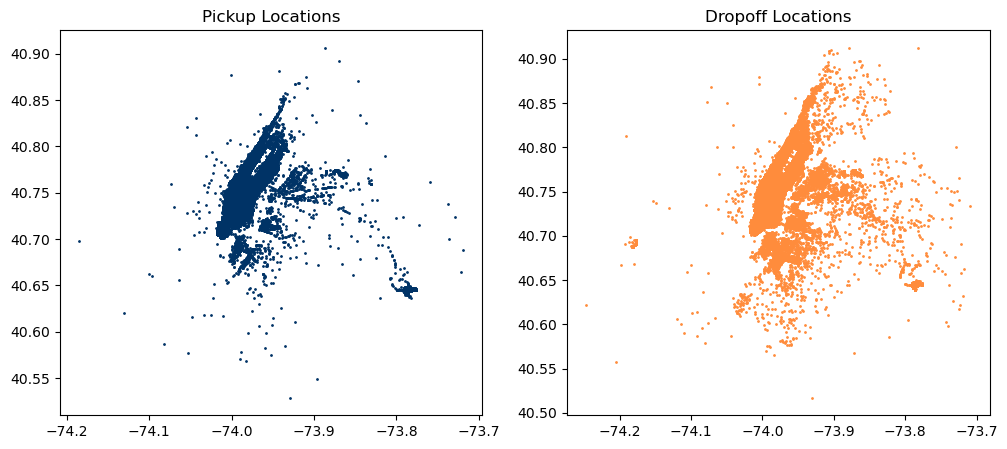

In [124]:
# scatter plots of pickups and dropoffs

# container
plt.figure(figsize = (12, 5))

# subplots
plot1 = plt.subplot(1, 2, 1)
plot2 = plt.subplot(1, 2, 2)

plot1.scatter(taxi['pickup_longitude'], taxi['pickup_latitude'], s = 1, color = '#003366')
plot1.set_title('Pickup Locations')

plot2.scatter(taxi['dropoff_longitude'], taxi['dropoff_latitude'], s = 1, color = '#ff8c3c')
plot2.set_title('Dropoff Locations');

plt.savefig('../images/scatterplots_all_pickups_and_dropoffs2.png');

The charts paint an accurate picture of pickups and dropoffs.<br>
Lastly, let's take a quick look at the `key` column to confirm every time stamp is unique.

-----
**Column**: `key`

In [138]:
taxi['key'].duplicated().sum()

0

There are zero duplicates, every row is its own unique ride.  Let's make the `key` column the index for this clean dataset.

In [141]:
# set index
taxi.set_index('key', inplace = True)
# sort index
taxi.sort_index(inplace = True)

In [143]:
# confirm head
taxi.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day_of_week,hour,minute,geodesic_distance
key,,,,,,,,,,,,
2009-01-01 00:48:11.000000200,11.0,-73.993578,40.721298,-73.967109,40.756657,4,2009,January,Thursday,0,48,4.518465
2009-01-01 00:54:13.000000100,12.2,-73.985358,40.744602,-73.956073,40.778083,2,2009,January,Thursday,0,54,4.465243
2009-01-01 01:07:13.000000100,5.4,-73.978859,40.750516,-73.968175,40.758468,1,2009,January,Thursday,1,7,1.262464
2009-01-01 01:12:02.000000100,11.0,-73.987317,40.768627,-74.007565,40.740797,1,2009,January,Thursday,1,12,3.531973
2009-01-01 04:34:56.000000100,8.2,-73.988965,40.736905,-74.001923,40.747579,1,2009,January,Thursday,4,34,1.613340


In [145]:
# confirm tail
taxi.tail()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day_of_week,hour,minute,geodesic_distance
key,,,,,,,,,,,,
2014-12-31 21:09:00.000000105,8.0,-74.002937,40.760222,-74.005120,40.742810,6,2014,December,Wednesday,21,9,1.942356
2014-12-31 21:12:05.000000400,9.5,-73.983158,40.749599,-73.995832,40.764279,1,2014,December,Wednesday,21,12,1.950120
2014-12-31 21:14:00.000000530,16.0,-73.983393,40.722055,-74.006947,40.741715,2,2014,December,Wednesday,21,14,2.953889
2014-12-31 21:56:56.000000400,10.0,-73.983126,40.773427,-73.956101,40.773936,1,2014,December,Wednesday,21,56,2.282213
2014-12-31 22:04:00.000000175,7.0,-73.975483,40.757470,-73.981932,40.775267,1,2014,December,Wednesday,22,4,2.049981


----
**Summary**<br>
This dataset is clean and ready for exploratory data analysis.  A total of 6,647 rows were discarded, which is 11% of the initial dataset.  Save a copy for future use.

In [151]:
taxi.to_csv('../data/clean_data/taxi_clean_set_v1.csv')

----
**Conclusion**

Given the available data, predicting a yellow cab fare in NYC, as well as the estimated ride distance is possible.  However, the final model yielded a RMSE of 3.60 dollars.  At first glance, that's a good performance, but the base fare for a cab ride in NYC is 2.50 dollars, so trying to get the RMSE below that threshold is important since a very short ride may end up with a predicted fare that's below the base.

---
**Recommendations**

Version 2.0, which aims to improve RMSE should take into account the following:<br>
* Going back to the EDA section to deeper explore identified relationships between features.
* For some of the engineered features, dissect the data into more granular form.  For example, expanding weekend rides to include rides taking place on Fridays past noon (Friday has the highest rides), as well as start counting the holiday rides on Thanksgiving week rather than the whole month of November.
* Clustering: Ignore to a certain degree the silhouette scores and focus more on building smaller, localized pickup and dropoff clusters around local landmarks known to draw high passenger traffic, such as baseball stadiums, Madison Square Garden, Grand Central Station, Penn Station, Columbus Circle, Wall Street, Times Square, etc.<br>

Exploring all these possibilities and employing more in-depth feature engineering, may help make version 2.0 even more accurate.